# Part 1: Training ResNet on MNIST

In [5]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [6]:
## Define trainning function
def train_epoch(model, device, train_loader, optimizer, criterion):
    # Set model to training mode (enables dropout, batch norm training behavior)
    model.train()
    
    # Track total loss across all batches
    running_loss = 0.0
    
    # Loop through each batch of training data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU/CPU
        data, target = data.to(device), target.to(device)
        
        # Clear old gradients from previous batch
        optimizer.zero_grad()
        
        # FORWARD PASS: Feed data through model to get predictions
        output = model(data)
        
        # Calculate how wrong the predictions are (loss)
        loss = criterion(output, target)
        
        # BACKWARD PASS: Calculate gradients (how to adjust weights)
        loss.backward()
        
        # UPDATE WEIGHTS: Apply the gradients to improve model
        optimizer.step()
        
        # Accumulate loss for reporting
        running_loss += loss.item()
    
    # Return average loss per batch
    avg_loss = running_loss / len(train_loader)
    return avg_loss

In [7]:
# Define Validation Function
def validate_epoch(model, device, val_loader, criterion):
    # Set model to evaluation mode (disables dropout, uses running batch norm stats)
    model.eval()
    
    # Track validation loss and correct predictions
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Disable gradient calculation (saves memory, faster computation)
    with torch.no_grad():
        # Loop through validation batches
        for data, target in val_loader:
            # Move data to GPU/CPU
            data, target = data.to(device), target.to(device)
            
            # Get model predictions
            output = model(data)
            
            # Calculate loss
            val_loss += criterion(output, target).item()
            
            # Get predicted class (digit with highest probability)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    # Calculate averages
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    
    return avg_val_loss, val_accuracy

In [8]:
# Define Plotting Function
def plot_results(train_losses, val_losses, val_metrics):
    # Create figure with 2 side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # X-axis: epoch numbers (1, 2, 3, ...)
    epochs = range(1, len(train_losses) + 1)
    
    # LEFT PLOT: Training vs Validation Loss
    axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # RIGHT PLOT: Validation Accuracy
    axes[1].plot(epochs, val_metrics, 'g-', label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
# Set Random Seeds for Reproducibility
seed = 2025
random.seed(seed)                              # Python random module
np.random.seed(seed)                           # NumPy random
torch.manual_seed(seed)                        # PyTorch CPU random
torch.cuda.manual_seed_all(seed)               # PyTorch GPU random
torch.backends.cudnn.deterministic = True      # Make CUDA deterministic
torch.backends.cudnn.benchmark = False         # Disable auto-tuning

# Check if GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")


# Hyperparameters
epochs = 15          
batch_size = 128    

Using device: cpu


In [10]:
# Load and Prepare Data
# MNIST normalization (mean=0.1307, std=0.3081 from dataset statistics)
normalize = transforms.Normalize((0.1307,), (0.3081,))
train_tfms = transforms.Compose([transforms.ToTensor(), normalize])
test_tfms = transforms.Compose([transforms.ToTensor(), normalize])

# Download MNIST dataset
full_train_set = datasets.MNIST("./data", train=True, download=True,
                                transform=train_tfms)
test_set = datasets.MNIST("./data", train=False, download=True,
                          transform=test_tfms)

# Split training data: 48,000 for training, 12,000 for validation
train_size = 48000
val_size = len(full_train_set) - train_size  # 12,000

train_set, val_set = random_split(
    full_train_set, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# Create data loaders (handles batching and shuffling)
num_workers = 2 if use_cuda else 0
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

print(f"Training samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:03<00:00, 2865401.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 565386.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4786859.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1954501.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [11]:
# Initialize the model
def build_resnet18_mnist(num_classes: int = 10) -> nn.Module:
    # Load ResNet-18 architecture without pre-trained weights
    model = models.resnet18(weights=None)
    
    # Modify first layer: 1 input channel for grayscale images (instead of 3 for RGB)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify final layer: 10 output classes for digits 0-9 (instead of 1000)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

model = build_resnet18_mnist().to(device)
print(f"\nModel has {sum(p.numel() for p in model.parameters())} parameters")


# Define the loss function (measures prediction error)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (algorithm to update weights)
# SGD = Stochastic Gradient Descent with momentum
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Define learning rate scheduler (gradually decreases learning rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Lists to store training history
train_losses, val_losses, val_accuracies = [], [], []

# Track the best model
best_val_acc = 0.0
best_model_state = None


Model has 11175370 parameters


In [12]:
for epoch in range(epochs):
    # TRAIN: Update model weights with training data
    train_loss = train_epoch(model, device, train_loader, optimizer, criterion)
    
    # VALIDATE: Check performance on validation data
    val_loss, val_acc = validate_epoch(model, device, val_loader, criterion)
    
    # Store metrics for later plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.2f}%")
    
    # Save best model (highest validation accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  --> New best model! (Val Acc: {best_val_acc:.2f}%)")
    
    # Update learning rate
    if scheduler is not None:
        scheduler.step()

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Epoch 1/15 - Train Loss: 0.3294, Val Loss: 0.1014, Val Acc: 96.95%
  --> New best model! (Val Acc: 96.95%)
Epoch 2/15 - Train Loss: 0.0648, Val Loss: 0.0861, Val Acc: 97.24%
  --> New best model! (Val Acc: 97.24%)
Epoch 3/15 - Train Loss: 0.0496, Val Loss: 0.0736, Val Acc: 97.78%
  --> New best model! (Val Acc: 97.78%)
Epoch 4/15 - Train Loss: 0.0498, Val Loss: 0.0835, Val Acc: 97.40%
Epoch 5/15 - Train Loss: 0.0407, Val Loss: 0.0519, Val Acc: 98.35%
  --> New best model! (Val Acc: 98.35%)
Epoch 6/15 - Train Loss: 0.0287, Val Loss: 0.0381, Val Acc: 98.78%
  --> New best model! (Val Acc: 98.78%)
Epoch 7/15 - Train Loss: 0.0248, Val Loss: 0.0540, Val Acc: 98.22%
Epoch 8/15 - Train Loss: 0.0198, Val Loss: 0.0397, Val Acc: 98.74%
Epoch 9/15 - Train Loss: 0.0166, Val Loss: 0.0367, Val Acc: 98.88%
  --> New best model! (Val Acc: 98.88%)
Epoch 10/15 - Train Loss: 0.0108, Val Loss: 0.0280, Val Acc: 99.17%
  --> New best model! (Val Acc: 99.17%)
Epoch 11/15 - Train Loss: 0.0083, Val Loss: 0.025


Plotting training curves...


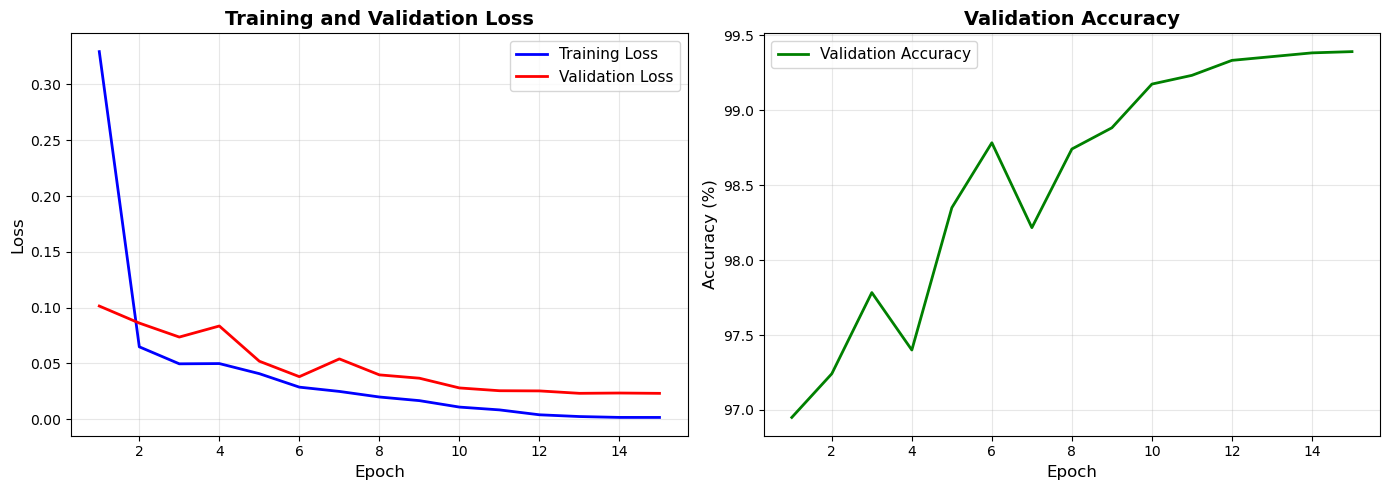

In [13]:
# Visualize Results
print("\nPlotting training curves...")
plot_results(train_losses, val_losses, val_accuracies)

In [14]:
# Test Final Model
# Load the best model for testing
print("\nLoading best model for testing...")
model.load_state_dict(best_model_state)

# Compute testing accuracy on unseen test data
print("Evaluating on test set...")
test_loss, test_acc = validate_epoch(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Loading best model for testing...
Evaluating on test set...
Test Loss: 0.0197
Test Accuracy: 99.44%
